In [1]:
!pip install langgraph langchain-openai

In [2]:
from dotenv import load_dotenv
load_dotenv()
import os
import json

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
import psycopg2
from psycopg2 import OperationalError

from openai import AzureOpenAI
import pandas as pd

/Users/akseth/CODE_WORKSPACE/VSCODE_LOCATION/agentic_ai/text2sql_api/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [3]:
def get_llm():
    """
    Initialize and return Azure OpenAI client.
    
    Requires environment variables:
    - AZURE_OPENAI_API_KEY: Your Azure OpenAI API key
    - AZURE_OPENAI_ENDPOINT: Your Azure OpenAI endpoint URL
    - AZURE_OPENAI_DEPLOYMENT_NAME: Your deployment name (model name)
    - AZURE_OPENAI_API_VERSION: API version
    """
    try:
        client = AzureOpenAI(
            api_key=os.getenv("AZURE_OPENAI_API_KEY"),
            api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
            azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
            azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
        )
        return client
    except Exception as e:
        print(f"Failed to initialize Azure OpenAI client: {e}")
        print("Please ensure the following environment variables are set:")
        print("- AZURE_OPENAI_API_KEY")
        print("- AZURE_OPENAI_ENDPOINT")
        print("- AZURE_OPENAI_DEPLOYMENT_NAME (optional, can be passed when making calls)")
        raise

In [4]:
def get_postgres_connection():
    try:
        conn = psycopg2.connect(
            host=os.getenv("POSTGRES_HOST"),
            port=os.getenv("POSTGRES_PORT"),
            dbname=os.getenv("POSTGRES_DB"),
            user=os.getenv("POSTGRES_USER"),
            password=os.getenv("POSTGRES_PASSWORD")
        )
        return conn
    except OperationalError as e:
        print(f"Database connection failed: {e}")
        raise

In [5]:
class Text2SQLState(TypedDict):

    metadata:str
    input_text: str
    generated_sql_query: str
    cleaned_query: str
    is_valid_sql: bool
    data: list[dict]
    summary: str
    chart: str
    followup_que: str
    max_iterations: int
    

In [6]:
def get_metadata(state: Text2SQLState):
    metadata_file_path = os.path.join(os.curdir, "metadata", "causal_inference_metadata.txt")
    try:
        with open(metadata_file_path, "r") as f:
            data = f.read()
            print(data)
            return {"metadata":data}
    except FileNotFoundError:
        print("File not found")
        return None

In [7]:
def generate_sql(state: Text2SQLState):

    sys_prompt = """
    You are an expert SQL query generator.
You will be given:
A natural language question
Database metadata (tables, columns, data types, relationships)
Your task is to generate only a single valid SQL query that answers the question.
Mandatory Rules:
Always fully qualify table names using the causal_inference schema
(e.g., causal_inference.table_name)
Never assume or use the public schema
Use only tables and columns explicitly defined in the metadata
Infer joins strictly from provided relationships
Do not add assumptions or fabricate fields
Do not include explanations, comments, markdown, or extra text
Output only executable SQL
Use ANSI SQL unless otherwise specified
    """
    user_prompt = f"""
    Question: {state["input_text"]}
    Database schema metadata: {state["metadata"]}
    """

    llm_obj = get_llm()
    response = llm_obj.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )   

    generated_sql_query = response.choices[0].message.content

    return {"generated_sql_query":generated_sql_query}

In [8]:

def validate_sql_query(state: Text2SQLState):
    """
    Validate a SQL query using LLM and return binary result (True/False).
    
    This function:
    - Removes markdown code blocks (```sql ... ```)
    - Uses LLM to validate SQL against database schema
    - Returns True if valid, False if invalid
    
    Args:
        sql_query: Raw SQL query string (may contain markdown formatting)
    
    Returns:
        tuple: (is_valid: bool, cleaned_query: str)
            - is_valid: True if query is valid, False otherwise
            - cleaned_query: Cleaned SQL query string
    """
    sql_query = state["generated_sql_query"]

    if not sql_query or not isinstance(sql_query, str):
        return {"is_valid_sql": False, "cleaned_query": ""}
    
    # Remove markdown code blocks if present
    cleaned_query = sql_query.strip()
    
    # Remove markdown code fences (```sql, ```, etc.)
    if cleaned_query.startswith('```'):
        # Find the first newline after ```
        first_newline = cleaned_query.find('\n')
        if first_newline != -1:
            cleaned_query = cleaned_query[first_newline + 1:]
        else:
            # No newline, just remove the ```
            cleaned_query = cleaned_query[3:]
    
    # Remove closing ```
    if cleaned_query.endswith('```'):
        cleaned_query = cleaned_query[:-3]
    
    # Strip whitespace
    cleaned_query = cleaned_query.strip()
    
    # Basic validation - check if query is empty
    if not cleaned_query:
        return {"is_valid_sql": False, "cleaned_query": cleaned_query}
    
    # Get metadata for validation
    llm_obj = get_llm()
    
    sys_prompt = """
    You are an expert SQL validator. Your task is to validate SQL queries against a database schema.
    
    Analyze the provided SQL query and check:
    1. Syntax correctness (valid SQL syntax)
    2. Schema compliance (tables and columns exist in the metadata)
    3. Schema qualification (tables use causal_inference schema)
    4. Column existence (all referenced columns exist in their respective tables)
    5. Join correctness (joins are valid based on relationships)
    6. Data type compatibility (operations are compatible with column types)
    
    Respond with ONLY a single word: "VALID" if the query is valid, or "INVALID" if it has any issues.
    Do not provide explanations, just the single word response.
    """
    
    user_prompt = f"""
    Database schema metadata:
    {state["metadata"]}
    
    SQL Query to validate:
    {cleaned_query}
    
    Is this SQL query valid? Respond with only "VALID" or "INVALID".
    """
    
    try:
        response = llm_obj.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.1  # Low temperature for consistent validation
        )
        
        validation_result = response.choices[0].message.content.strip().upper()
        
        # Check if response indicates valid query
        is_valid = "VALID" in validation_result and "INVALID" not in validation_result
        
        return {"is_valid_sql": is_valid, "cleaned_query": cleaned_query}
        
    except Exception as e:
        print(f"Error during LLM validation: {e}")
        # Fallback: return False if LLM validation fails
        return {"is_valid_sql": False, "cleaned_query": cleaned_query}

In [9]:
def execute_sql(state: Text2SQLState):
    """
    Execute a SQL query and return the results.
    
    Args:
        sql_query: SQL query string to execute (will be validated and cleaned)
    
    Returns:
        list: List of dictionaries, where each dictionary represents a row
              with column names as keys
    
    Raises:
        ValueError: If the SQL query is invalid
    """
    try:
        # Use cleaned_query if available, otherwise fall back to generated_sql_query
        sql_to_execute = state.get("cleaned_query") or state.get("generated_sql_query")
        
        if not sql_to_execute:
            raise ValueError("No SQL query available to execute")
        
        conn = get_postgres_connection()
        cursor = conn.cursor()
        cursor.execute(sql_to_execute)
        
        # Get column names
        columns = [desc[0] for desc in cursor.description]
        
        # Fetch all rows and convert to list of dictionaries
        rows = cursor.fetchall()
        results = [dict(zip(columns, row)) for row in rows]

        cursor.close()
        conn.close()
        
        return {"data": results}
    
    except Exception as e:
        print(f"Error executing SQL query: {e}")
        print(f"Query: {sql_to_execute}")
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()
        raise
    

In [10]:
def generate_summary(state: Text2SQLState):
    """
    Generate a concise 4-5 line summary of the given data using LLM.
    
    Args:
        data: List of dictionaries representing query results, or pandas DataFrame
    
    Returns:
        str: A 4-5 line summary of the data insights
    """
    data = state["data"]
    if not data:
        return {"summary": "No data available to summarize."}
    
    # Convert to DataFrame if it's a list of dictionaries
    if isinstance(data, list):
        df = pd.DataFrame(data)
    elif isinstance(data, pd.DataFrame):
        df = data.copy()
    else:
        return {"summary": "Invalid data format. Expected list of dictionaries or DataFrame."}
    
    if df.empty:
        return {"summary": "The query returned no results."}
    
    # Get basic statistics about the data
    num_rows = len(df)
    num_cols = len(df.columns)
    column_names = list(df.columns)
    
    # Convert data to a readable format for LLM
    # Limit to first 10 rows to avoid token limits
    sample_data = df.head(10).to_dict('records')
    
    # Get summary statistics for numeric columns
    numeric_summary = {}
    for col in df.select_dtypes(include=['number']).columns:
        numeric_summary[col] = {
            'min': float(df[col].min()),
            'max': float(df[col].max()),
            'mean': float(df[col].mean()),
            'sum': float(df[col].sum())
        }
    
    llm_obj = get_llm()
    
    sys_prompt = """
    You are a data analyst expert. Your task is to analyze query results and generate a concise,
    insightful summary in exactly 4-5 lines.
    
    Rules:
    - Write exactly 4 lines (not more, not less)
    - Focus on key insights, trends, and important findings
    - Use clear, business-friendly language
    - Highlight the most significant data points
    - If there are comparisons (e.g., historical vs current), emphasize the differences
    - Be specific with numbers when relevant
    - Do not include markdown formatting or bullet points
    - Write in paragraph form, with each line being a complete sentence
    """
    
    user_prompt = f"""
    Analyze the following query results and generate a 4-5 line summary:
    
    Data Overview:
    - Number of rows: {num_rows}
    - Number of columns: {num_cols}
    - Column names: {', '.join(column_names)}
    
    Sample data (first {min(10, num_rows)} rows):
    {json.dumps(sample_data, indent=2, default=str)}
    
    Numeric column statistics:
    {json.dumps(numeric_summary, indent=2) if numeric_summary else "No numeric columns"}
    
    Generate a concise 4-5 line summary that highlights the key insights from this data.
    """
    
    try:
        response = llm_obj.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.3  # Moderate temperature for balanced creativity and consistency
        )
        
        summary = response.choices[0].message.content.strip()
        
        # Ensure it's approximately 4-5 lines (split by periods or newlines)
        lines = [line.strip() for line in summary.split('\n') if line.strip()]
        if len(lines) < 4:
            # If too few lines, try splitting by sentences
            sentences = [s.strip() for s in summary.split('.') if s.strip()]
            if len(sentences) >= 4:
                summary = '. '.join(sentences[:5]) + '.' if len(sentences) > 5 else '. '.join(sentences) + '.'
        elif len(lines) > 5:
            # If too many lines, take first 5
            summary = '\n'.join(lines[:5])
        
        return {"summary":summary}
    
    except Exception as e:
        print(f"Error generating summary: {e}")
        # Fallback to basic summary
        return {"summary": f"Query returned {num_rows} rows with {num_cols} columns: {', '.join(column_names)}."}

In [11]:
def get_followup_que(state: Text2SQLState):
    """
    Generate suggested questions based on the database metadata.
    
    Args:
        count: Number of suggested questions to generate (default: 3)
    
    Returns:
        list: List of suggested questions as strings
    """
    llm_obj = get_llm()
    count=3
    
    sys_prompt = """
    You are an expert at analyzing database schemas and generating relevant business questions.
    Based on the provided database metadata, generate natural language questions that users might ask
    to analyze their business data.
    
    Rules:
    - Generate questions that are relevant to the tables, columns, and relationships described in the metadata
    - Questions should be business-focused and actionable
    - Questions should be clear and specific
    - Each question should be on a separate line
    - Do not include numbering, bullets, or markdown formatting
    - Output only the questions, one per line
    """
    
    user_prompt = f"""
    Database schema metadata: {state["metadata"]}
    
    Generate exactly {count} relevant business questions that can be answered using this database.
    Output only the questions, one per line, without any numbering or formatting.
    """
    
    try:
        response = llm_obj.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": user_prompt}
            ]
        )
        
        # Extract questions from response
        questions_text = response.choices[0].message.content.strip()
        
        # Split by newlines and clean up
        questions = [q.strip() for q in questions_text.split('\n') if q.strip()]
        
        # Remove any numbering or bullets if present
        questions = [q.lstrip('0123456789.-) ').strip() for q in questions]
        
        # Return the requested number of questions
        return {"followup_que":questions[:count]}
    
    except Exception as e:
        print(f"Error generating suggested questions: {e}")
        raise

In [12]:
def generate_chart(state: Text2SQLState):
    return {"generate_chart":""}

In [13]:
def check_condition(state: Text2SQLState) -> Literal["execute_sql","generate_sql"]:

    if state['is_valid_sql']:
        return "execute_sql"
    else:
        return "generate_sql"

In [14]:
graph = StateGraph(Text2SQLState)

graph.add_node("get_metadata", get_metadata)
graph.add_node("generate_sql", generate_sql)
graph.add_node("validate_sql_query", validate_sql_query)
graph.add_node("execute_sql", execute_sql)
graph.add_node("generate_summary", generate_summary)
graph.add_node("generate_chart", generate_chart)
graph.add_node("get_followup_que", get_followup_que)

graph.add_edge(START, "get_metadata")
graph.add_edge("get_metadata", "get_followup_que")
graph.add_edge("get_metadata", "generate_sql")
graph.add_edge("generate_sql", "validate_sql_query")
graph.add_conditional_edges("validate_sql_query",check_condition)
graph.add_edge("execute_sql", "generate_chart")
graph.add_edge("execute_sql","generate_summary")

graph.add_edge("generate_chart", END)
graph.add_edge("generate_summary", END)
graph.add_edge("get_followup_que", END)

workflow = graph.compile()

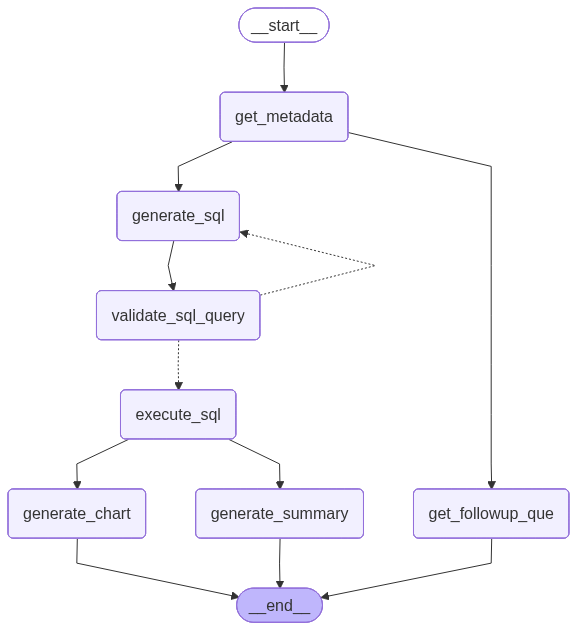

In [15]:
workflow

In [16]:
input_text = "How do historical sales compare to current year sales for the Beverages category across all stores?"

initial_state = {
    "input_text":input_text
}

workflow.invoke(initial_state)

"SCHEMA_NAME""causal_inference"

historical_sales:### This table is relevant for questions like: - “What are my top or worst performing categories?” - “What are the top performing products in category(e.g.,'Fruits and Vegetables','Pantry','Meat and Seafood','Bakery and Bread','Frozen Food','Deli and Prepared Food','Dairy and Eggs','Beverages')?” - “What are the worst performing products in category(e.g.,'Fruits and Vegetables','Pantry','Meat and Seafood','Bakery and Bread','Frozen Food','Deli and Prepared Food','Dairy and Eggs','Beverages')?” - “How did my categories perform last week?” ### Table description: The `historical_sales` table contains **previous year’s sales data** across items, stores, and categories. It is **essential for comparing current sales to last year’s**, helping to measure trends, growth, or decline over time. ### When to Use: Use this table for any analysis that requires **year-over-year (YoY) comparison**, especially to: - Compare last week’s sales vs. the same

{'metadata': '"SCHEMA_NAME""causal_inference"\n\nhistorical_sales:### This table is relevant for questions like: - “What are my top or worst performing categories?” - “What are the top performing products in category(e.g.,\'Fruits and Vegetables\',\'Pantry\',\'Meat and Seafood\',\'Bakery and Bread\',\'Frozen Food\',\'Deli and Prepared Food\',\'Dairy and Eggs\',\'Beverages\')?” - “What are the worst performing products in category(e.g.,\'Fruits and Vegetables\',\'Pantry\',\'Meat and Seafood\',\'Bakery and Bread\',\'Frozen Food\',\'Deli and Prepared Food\',\'Dairy and Eggs\',\'Beverages\')?” - “How did my categories perform last week?” ### Table description: The `historical_sales` table contains **previous year’s sales data** across items, stores, and categories. It is **essential for comparing current sales to last year’s**, helping to measure trends, growth, or decline over time. ### When to Use: Use this table for any analysis that requires **year-over-year (YoY) comparison**, especia

#### Sequential workflow

In [17]:
class SeqState(TypedDict):
    Reading:str

In [18]:
def methid1(state:SeqState):
    pass

def methid2(state:SeqState):
    pass

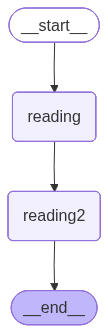

In [19]:
graph1 = StateGraph(SeqState)

graph1.add_node("reading", methid1)
graph1.add_node("reading2", methid2)

graph1.add_edge(START, "reading")
graph1.add_edge("reading", "reading2")


graph1.add_edge("reading", END)

graph1.compile()



#### Parallel Workflopw

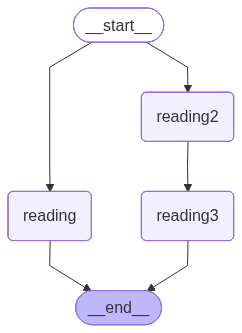

In [20]:
graph1 = StateGraph(SeqState)

graph1.add_node("reading", methid1)
graph1.add_node("reading2", methid2)
graph1.add_node("reading3", methid1)

graph1.add_edge(START, "reading")
graph1.add_edge(START, "reading2")
graph1.add_edge("reading2", "reading3")


graph1.add_edge("reading", END)
graph1.add_edge("reading3", END)

graph1.compile()